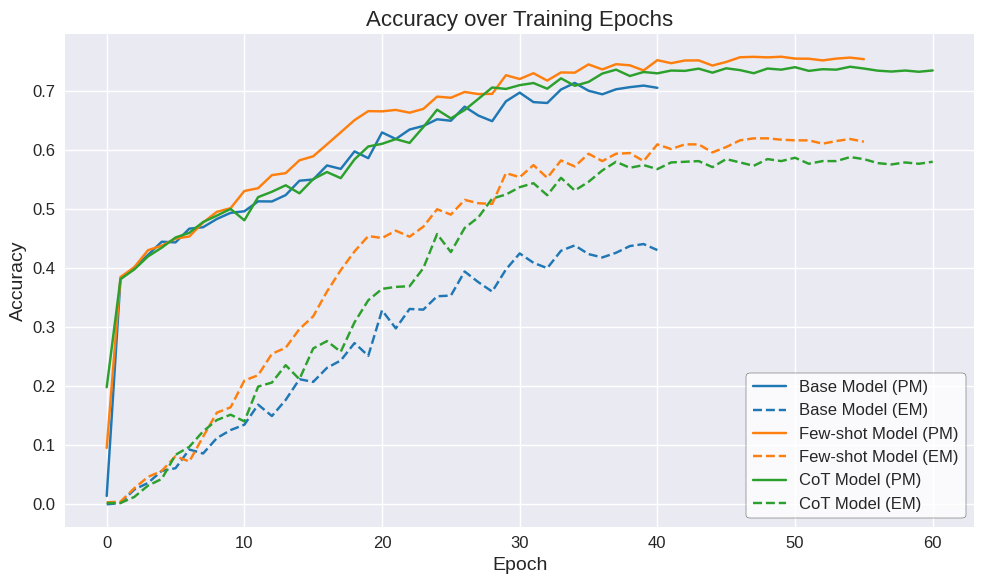

In [34]:
import json
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fontsize = 12

plt.rcParams.update({
    "font.size": fontsize,
    "axes.labelsize": fontsize + 2,
    "axes.titlesize": fontsize + 4,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.frameon": True,
})

def plot_history(histories):
    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (label, history) in enumerate(histories.items()):
        epochs = []
        metrics = []
        metrics2 = []
        for record in history:
            metric = "eval_exact_match_accuracy"
            metric2 = "eval_part_match_accuracy"
            if metric in record and "epoch" in record:
                epochs.append(record["epoch"])
                metrics.append(record[metric])
                metrics2.append(record[metric2])
        
        plt.plot(epochs, metrics2, label=label + " (PM)", color=colors[i], linestyle="-")
        plt.plot(epochs, metrics, label=label + " (EM)", color=colors[i], linestyle="--")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Training Epochs")
    legend = plt.legend()
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_edgecolor("black")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../figures/train_em.png", dpi=300)
    plt.show()


def read_history(file_name: str):
    with open(file_name, mode="r") as f:
        return json.load(f)

models = {
    "Base Model": "/home/nub/Bachelor/bachelor-thesis/models/finqa_base_10/log_history.json",
    "Few-shot Model": "/home/nub/Bachelor/bachelor-thesis/models/finqa_base_10_no_ex/log_history.json",
    "CoT Model": "/home/nub/Bachelor/bachelor-thesis/models/finqa_base_10_no_cot/log_history.json",
}
histories = {k: read_history(v) for k, v in models.items()}

# Usage
plot_history(histories)